In [1]:
import time 

import pandas as pd

import numpy as np

import plotly.express as px

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse

from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.linear_model import Lasso, Ridge, LinearRegression

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

import lightgbm as lgb

In [2]:
SEED = 12345

# Определение стоимости автомобилей

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Осмотр-данных" data-toc-modified-id="Осмотр-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Осмотр данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Осмотр данных

Загрузим данные и сделаем первичный осмотр.

In [3]:
df = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])

Признаки:

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
    
Целевой признак:

    Price — цена (евро)

Выведем первые несколько строк нашей таблицы и посмотрим на них, чтобы понять структуру данных и значения, скоторыми предстоит работать.

In [4]:
display(df.head(3))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


Посмотрим на типы данных в таблице.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Сохраним изначальный размер датасета в отдельную <b>константу</b> - она пригодится нам позже.

In [6]:
INITIAL_DF_LENGTH = df.shape[0]

Следующая функция понадобится нам для оценки изменения размеров датасета после производимых нами действий.

In [7]:
def size_change(new_df_length, old_df_length):
    '''
    This function will display difference in percent for two datasets.
    '''
    percent = (100 - (new_df_length/old_df_length)*100)
    
    print(f'Размер изначального датасета: {old_df_length} строк')
    print(f'Размер датасета сейчас: {new_df_length} строк')
    print(f'Датасет сократился на {percent:.4} %')

Выведем на экран количество "грубых повторов" aka продублированных строк - то есть таких строк в которых полностью повторяются данные во всех колонках. Именно такому термину нас научили в ЯП.

In [8]:
print(f'Повторяющихся строк: {df.duplicated().sum()} что составляет {(df.duplicated().sum() / df.shape[0]):.2%}' )

Повторяющихся строк: 4 что составляет 0.00%


Избавимся от грубых повторов - благо их совсем мало.

In [9]:
df.drop_duplicates(inplace=True)

Посмотрим на количество пропусков в таблице.

Следующая функция выведет таблицу в которой индексами будут названия колонок, а в столбцах будут записаны количество пропусков в абсолютном и процентном представлении для этой строке. Данные будут отсортированы по убыванию.

In [10]:
def show_na(df):
    '''
    This function will return table with missed values in each column of a dataset in percents and avsolute values.
    '''
    data_info = (df.isna() | df.isnull()).sum()
    res = (pd.concat(
        [(data_info / df.shape[0] * 100).round(2), data_info], 
        axis=1,  
        keys=['percent', 'count']).sort_values('percent', ascending=False))
    return res

In [11]:
show_na(df)

,percent,count
NotRepaired,20.08,71154
VehicleType,10.58,37490
FuelType,9.28,32895
Gearbox,5.60,19833
Model,5.56,19705
DateCrawled,0.00,0
Price,0.00,0
RegistrationYear,0.00,0
Power,0.00,0
Kilometer,0.00,0


Следующая функция поможет нам более подробно посмотреть на каждый столбец.

In [12]:
def histogram_boxplot(data,
                      xlabel=None,
                      title=None,
                      font_scale=1,
                      figsize=(16, 8),
                      bins=None):
    """ Диграмма размаха и гистограмма будут отрисованны вместе на одном кадре. 
    На графиках будут также нарисованны линия среднего и медианы.
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 1)
    figsize: size of fig (default (16, 8))
    bins: number of bins (default None / auto)
    """
    
    sns.set(font_scale=font_scale)
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)},
        figsize=figsize
    )
    sns.boxplot(x=data, ax=ax_box2)
    
    if bins:
        sns.histplot(x=data, ax=ax_hist2, bins=bins, kde=True)
    else:
        sns.histplot(data, ax=ax_hist2, kde=True)

    plt.axvline(x=data.mean(), linewidth=2, color='r', label="mean", alpha=0.8)
    plt.axvline(x=data.median(),
                linewidth=2,
                color='y',
                label="median",
                alpha=0.8)
    ax_hist2.legend()

    if xlabel:
        ax_hist2.set(xlabel=xlabel)
    if title:
        ax_box2.set(title=title)
    plt.show()    

In [13]:
def info_column(column_name, data, bins=None, plot=True):
    
    '''Функция смотри тип данных в столбце:
    - если тип object, то смотрит уникальные значения
    - в противном случае оценивается распределение'''
    
    if column_name.dtype == 'object':
        
        print(column_name.name)
        print(column_name.unique())
        print()
        print(column_name.describe())
        
    else:
        bins=bins
        print(column_name.name)
        print(column_name.describe())
        if plot:
            histogram_boxplot(column_name, xlabel=column_name.name, title = 'Распределение '+ column_name.name)        

`DateCrawled` - бесполезная колонка - цена не может зависеть от даты выгрузки объявления из базы. Стоит однако отметить, что последний раз объявления выгружались из базы 7 апреля 2016 года.

In [14]:
info_column(df['VehicleType'], df)

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

count     316875
unique         8
top        sedan
freq       91457
Name: VehicleType, dtype: object


~10.6% пропусков в колонке с типом кузова авто. Попробуем обработать позже.

RegistrationYear
count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


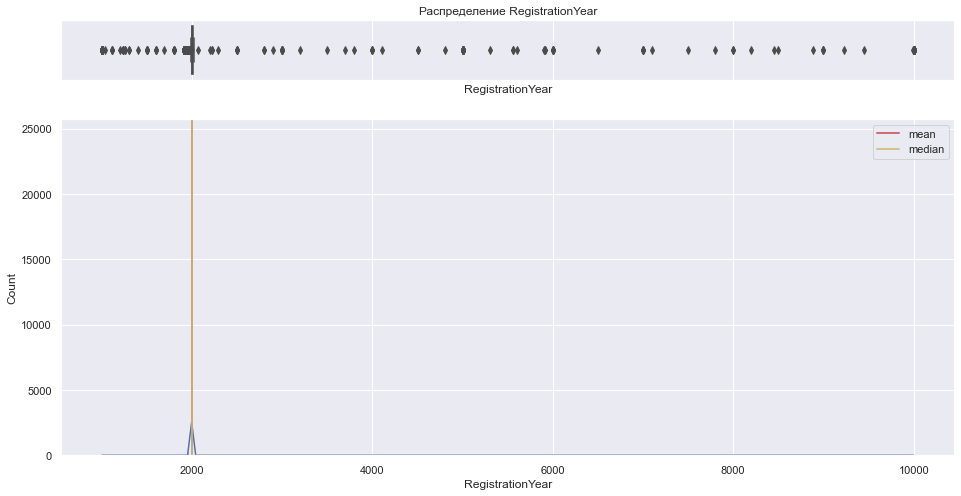

In [15]:
info_column(df['RegistrationYear'], df)

Год регистрации автомобиля	Странные выбросы. Оставим в таблице данные для машин с 1900 года (может у кого-то действительно очень старая машина) по 2016 - это год когда делалась выгрузка и значит у нас не может быть машин из будущего. Стоить заметить, что год выпуска для нашей модели не интересен в сыром виде. Стоит преобразовать его в количество лет с момента выпуска.

In [16]:
info_column(df['Gearbox'], df)

Gearbox
['manual' 'auto' nan]

count     334532
unique         2
top       manual
freq      268249
Name: Gearbox, dtype: object


Тип коробки передач. В столбце >5.5% пропусков. Врядли что-то сможем с этим делать. Но сам параметр важен.

Power
count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


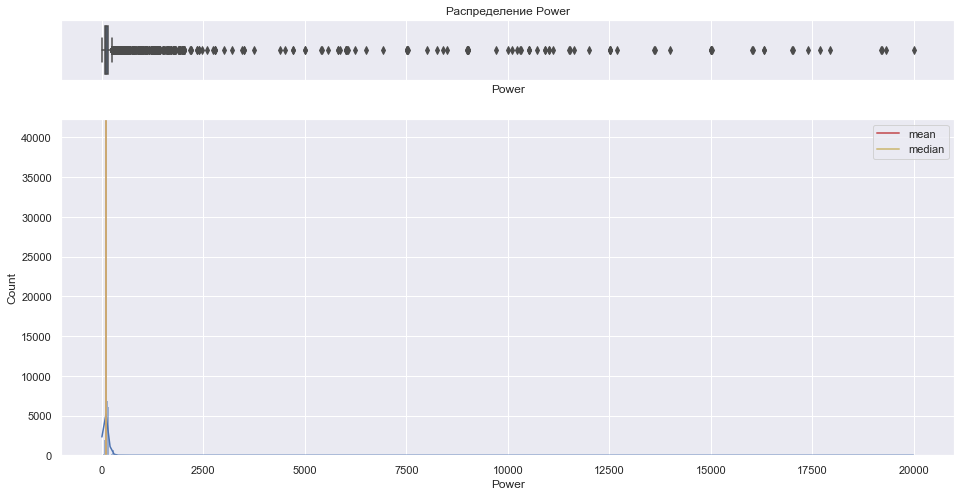

In [17]:
info_column(df['Power'], df, True)

Мощность авто. На графике видно (особенно если приблизить), что в данных есть анамалия. И даже не одна. Первая - пик на нулевых значениях. Вторая - куча значений, превышающих логичные 300 лошадиных сил. Постараемся привести эти данные к нормальному виду позже.

In [18]:
info_column(df['Model'], df)

Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leo

Модель автомобиля. >5% пропусков. Представляется сомнительным возможность востановить данные.

Kilometer
count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


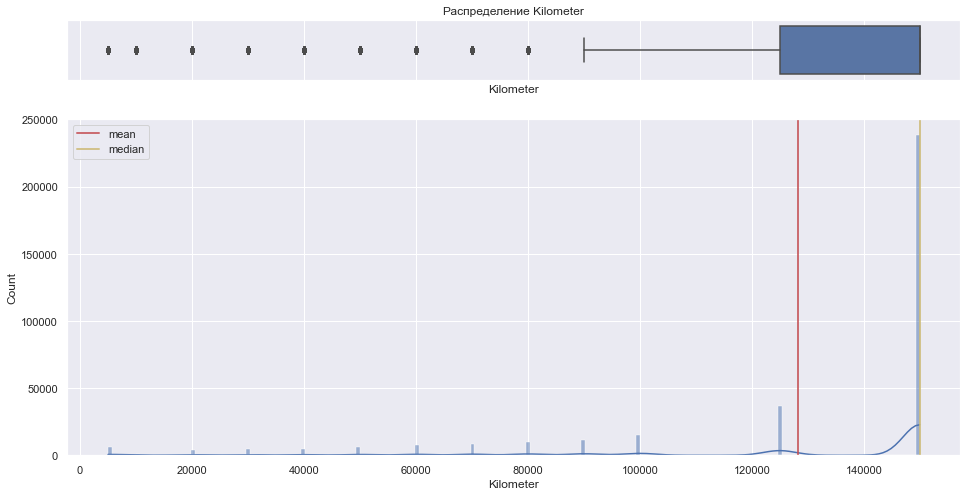

In [19]:
info_column(df['Kilometer'], df)

Пробег в километрах. Пропусков нет и значения в нормальном диапазоне. Не будем трогать.

RegistrationMonth
count    354365.000000
mean          5.714650
std           3.726432
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64


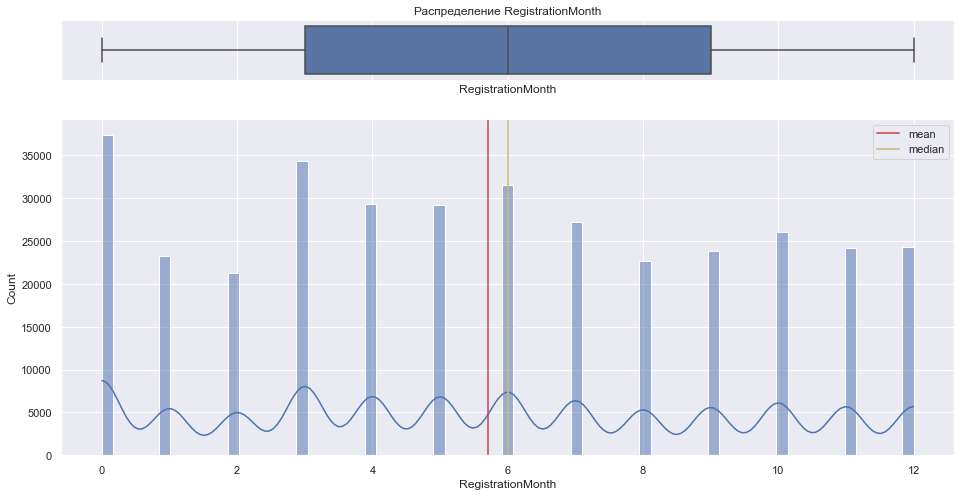

In [20]:
info_column(df['RegistrationMonth'], df)

Месяц регистрации автомобиля. Пропусков нет, но есть значения равные 0. Вообще этот параметр лучше использовать в связке с годом регистрации. Возможно объеденим эти два столбца.

In [21]:
info_column(df['FuelType'], df)

FuelType
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

count     321470
unique         7
top       petrol
freq      216349
Name: FuelType, dtype: object


Тип топлива. >9% пропусков. Представляется сомнительным возможность востановить данные.

In [22]:
info_column(df['Brand'], df)

Brand
['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']

count         354365
unique            40
top       volkswagen
freq           77012
Name: Brand, dtype: object


Марка автомобиля. Пропусков нет, данные выглядят адекватными.

In [23]:
info_column(df['NotRepaired'], df)

NotRepaired
[nan 'yes' 'no']

count     283211
unique         2
top           no
freq      247158
Name: NotRepaired, dtype: object


Была машина в ремонте или нет. 20% владельцев решили не указывать эту информацию. Возможно стоить исходить из рассуждения, что лучше считать эти машины отремонтированными так как лучше предлагать покупателю неотремонтированную машину за меньшую цену, чем битую по цене целой.

In [24]:
display(df['DateCreated'].sort_values().head())
display(df['DateCreated'].sort_values().tail())

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
Name: DateCreated, dtype: datetime64[ns]

184411   2016-04-07
262340   2016-04-07
214462   2016-04-07
241969   2016-04-07
260600   2016-04-07
Name: DateCreated, dtype: datetime64[ns]

Дата создания анкеты. Крайняя дата совпадает с последней датой выгрузки данных из базы. Это значит, что данные актуальные. Подавляюще большое количество объявлений были размещены в 2016 году, что невелирует возможность влияния на цену в зависимости от экономической ситуации. Для наших моделей по предсказанию цены данная информация представляется бесполезной.

In [25]:
info_column(df['NumberOfPictures'], df, plot=False)

NumberOfPictures
count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64


Количество фотографий автомобиля. Все значения нулевые - выкинем столбец как не несущий информации.

Price
count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


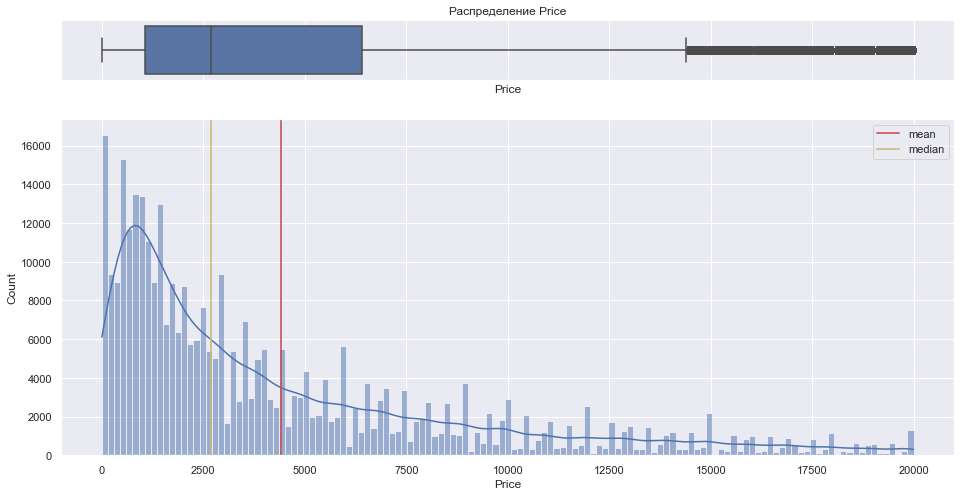

In [26]:
info_column(df['Price'], df)

Цена в евро. Целевой признак. В столбце есть нулевые значения. Осмотрим столбец и решим что с ними делать позже.

`PostalCode` - почтовый индекс владельца анкеты (пользователя).
    
Пропусков нет и явных аномалий тоже. Теоретически интересная фича - цена вполне может зависеть от региона продажи. Но есть проблема - данные представлены в цифровом формате и наша модель не поймет, что это категории. Теоретически можно поискать API и получить для каждого кода страну, но такое улучшение выходит за рамки моих возможностей. (тем более, что нормальные API для таких целей платные). Придется избавиться от столбца.

`LastSeen` - дата последней активности пользователя. Цена не может зависеть от того, когда пользователь заходил в интернет. Для наших целей данный сотлбец бесполезен.

### Подготовка данных

Для начала избавимся от того, что нам не понадобится.

In [27]:
df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode'], axis=1, inplace=True)

Посмотрим сколько автовладельцев хотят отдать свои машины бесплатно:

In [28]:
print(df.shape[0] - df.query('Price > 0').shape[0])
(100 - (df.query('Price > 0').shape[0] / df.shape[0]) * 100)

10772


3.0398035923412294

Три процента альтруистов. Наша задача определять цену авто, а не искать благотворителей, поэтому избавимся от этих строк.

In [29]:
df.query('Price > 0', inplace=True)

Теперь разберемся с годом регистрации авто. Сделаем срез с 1900 по 2016 год.

In [30]:
df.query('1900 < RegistrationYear < 2016', inplace=True)
size_change(df.shape[0], INITIAL_DF_LENGTH)

Размер изначального датасета: 354369 строк
Размер датасета сейчас: 320793 строк
Датасет сократился на 9.475 %


На очереди месяц. В колонке есть значения равные нулю. Но в жизне нет такого месяца. Поэтому заменим их все на еденицу.

In [31]:
df.RegistrationMonth.replace(0, 1, inplace=True)
df.RegistrationMonth.unique()

array([ 1,  5,  8,  6,  7, 10, 12, 11,  2,  3,  4,  9], dtype=int64)

Месяц регистрации авто сам по себе не очень важный параметр.Он работает только в связке с годом - авто выпущенное в январе 2014 почти на год старше чем авто выпущенное в декабре 2014. Поэтому добавим месяц как дробную часть к году и сохраним в отдельной колонке. Чтобы вес месяца у нас отражал, что декабрь самый последний, а январь наоборот идет вначале, вес будем считать по формуле $$\frac{месяц\ выпуска - 1}{12}$$, тогда получим, что январь имеет самый маленький вес 0, а декабрь напротив - самый большой 0,92

In [32]:
df['year_with_month'] = df['RegistrationYear'] + ((df['RegistrationMonth'] - 1) / 12)

In [33]:
df['year_with_month']

0         1993.000000
1         2011.333333
2         2004.583333
3         2001.416667
4         2008.500000
             ...     
354363    2000.166667
354365    2005.000000
354366    2000.166667
354367    1996.166667
354368    2002.416667
Name: year_with_month, Length: 320793, dtype: float64

И последнее, но не менее важное преобразование. Переведем получившееся значение в возраст автомобиля, чтобы при обучении модель правильно учитывала этот параметр.

In [34]:
df['Age'] = 2017 - df['year_with_month']

In [35]:
show_na(df)

,percent,count
NotRepaired,17.38,55761
FuelType,6.47,20754
Model,4.50,14430
Gearbox,4.48,14368
VehicleType,3.47,11145
Price,0.00,0
RegistrationYear,0.00,0
Power,0.00,0
Kilometer,0.00,0
RegistrationMonth,0.00,0


Теперь попробуем минимизировать пропуски в столбце с типом кузова автомобиля. Для этого сделаем словарь, где ключами будут марки авто, а значениями - тип(ы) кузова.

In [36]:
dict_model_vehicletype = dict(zip(df['Model'], df['VehicleType']))

In [37]:
def filling_vt(row, dictionary):
    if row['VehicleType'] != row['VehicleType']:
        return dictionary[row['Model']]
    else:
        return row['VehicleType']
    
df['VehicleType'] = df.apply(filling_vt, axis=1, args=(dict_model_vehicletype,))

In [38]:
show_na(df)

,percent,count
NotRepaired,17.38,55761
FuelType,6.47,20754
Model,4.50,14430
Gearbox,4.48,14368
VehicleType,0.98,3144
Price,0.00,0
RegistrationYear,0.00,0
Power,0.00,0
Kilometer,0.00,0
RegistrationMonth,0.00,0


Отлично, осталось меньше процента пропусков в колонке с типом кузова, против одинадцати процентов в изначальной таблице.

На очереди отметка о ремонте авто. Как мы уже упоминали ранее, проще и правильнее считать, что если владелец оставил это поле пустым, то машина была в ремонте. Это защитит интересы покупателя. Поэтому заполним пропуски в этой колонке значением `'no'`.

In [39]:
df['NotRepaired'].fillna('no', inplace=True)

In [40]:
show_na(df)

,percent,count
FuelType,6.47,20754
Model,4.50,14430
Gearbox,4.48,14368
VehicleType,0.98,3144
Price,0.00,0
RegistrationYear,0.00,0
Power,0.00,0
Kilometer,0.00,0
RegistrationMonth,0.00,0
Brand,0.00,0


Оставшиеся в таблице пропуски не представляется возможным заполнить чем-либо осмысленным. У нас нет зависимостей, которые мы могли бы использовать для этого. Поэтому будем заполнять дамми значением `unknown`

In [41]:
df.fillna('unknown', inplace=True)

In [42]:
show_na(df)

,percent,count
Price,0.0,0
VehicleType,0.0,0
RegistrationYear,0.0,0
Gearbox,0.0,0
Power,0.0,0
Model,0.0,0
Kilometer,0.0,0
RegistrationMonth,0.0,0
FuelType,0.0,0
Brand,0.0,0


Последнее, что нам осталось - это разобраться со столбцом `Power`.

Как было указано выше в данных есть аномалии. Посмотрим на таблицу с высокими значениями.

In [43]:
df.query('500 < Power < 1000')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,year_with_month,Age
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2005.250000,11.750000
6296,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2002.833333,14.166667
6504,3000,small,2009,manual,771,punto,125000,1,petrol,fiat,no,2009.000000,8.000000
6637,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,1996.583333,20.416667
8057,500,small,2002,manual,620,ypsilon,150000,12,petrol,lancia,no,2002.916667,14.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
328276,16500,sedan,2005,auto,507,m_reihe,150000,4,petrol,bmw,no,2005.250000,11.750000
328668,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2002.833333,14.166667
331252,4600,small,2008,manual,601,polo,80000,1,petrol,volkswagen,no,2008.000000,9.000000
344689,14900,suv,2006,auto,521,cayenne,150000,6,petrol,porsche,no,2006.416667,10.583333


Строка 4060 - Mitsubishi Colt. Как видно из источника https://www.drom.ru/catalog/mitsubishi/colt/g_2002_955/ этот автомобиль может быть или 95ти или 109ти сильным. У нас в строке значение 953, и можно сделать предположение, что при вводе значений пропустили точку и должно быть 95.3. 

Логично предположить, что многие значения внесены с подобной ошибкой и мы могли бы просто поделить все аномальные значения на 10. Но если посмотреть на строку 344689 мы увидим Porsche Cayenne, и судя по тому же источнику https://www.drom.ru/catalog/porsche/cayenne/g_2002_5301/ максимальная мощность для него может быть до 450 лошадиных сил с завода. Так что, в данном случае, немного прокачаный владельцем автомобиль вполне может показывать 521 силу, но точно не может 52.1.

Введем еще один фильтр - мощные машины премиального класса и посмотрим, что у нас попадет в эту категорию.

In [44]:
df.query('Power > 500 and Price > 11000').head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,year_with_month,Age
13373,18500,small,2002,auto,600,s_type,150000,12,unknown,jaguar,no,2002.916667,14.083333
17510,15500,coupe,2009,auto,507,m_reihe,150000,1,petrol,bmw,yes,2009.000000,8.000000
20145,18500,suv,2006,auto,521,cayenne,150000,5,petrol,porsche,no,2006.333333,10.666667
23188,11999,wagon,2002,auto,504,other,150000,12,petrol,audi,no,2002.916667,14.083333
25684,20000,sedan,2006,auto,507,m_reihe,150000,6,petrol,bmw,no,2006.416667,10.583333


Всего 63 строки. 

In [45]:
df.query('Power > 1000 and Price > 11000').head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,year_with_month,Age
45053,15800,convertible,2014,auto,10218,fortwo,30000,3,petrol,smart,no,2014.166667,2.833333
84226,18550,sedan,2013,manual,1288,c_klasse,90000,11,gasoline,mercedes_benz,no,2013.833333,3.166667
104463,11399,unknown,1995,manual,1995,unknown,150000,12,gasoline,bmw,no,1995.916667,21.083333
216993,11950,convertible,2008,manual,16312,a4,20000,4,petrol,audi,no,2008.250000,8.750000
227634,15499,wagon,2012,manual,13636,c_klasse,125000,4,gasoline,mercedes_benz,no,2012.250000,4.750000


План такой:
Пишем функцию, которая будет делить число на 10. Если результат попадает в диапазон до 700, то функция возвращает это число, если нет - повторяется цикл, пока число не попадет в заданый диапазон.

In [46]:
def horse_power_normalization(row):
    result = row['Power']
    while result > 700:
        result /= 10
    return result

In [47]:
df['Power'] = df.apply(horse_power_normalization, axis=1)

Power
count    320793.000000
mean        109.667397
std          62.674119
min           0.000000
25%          73.000000
50%         105.000000
75%         143.000000
max         700.000000
Name: Power, dtype: float64


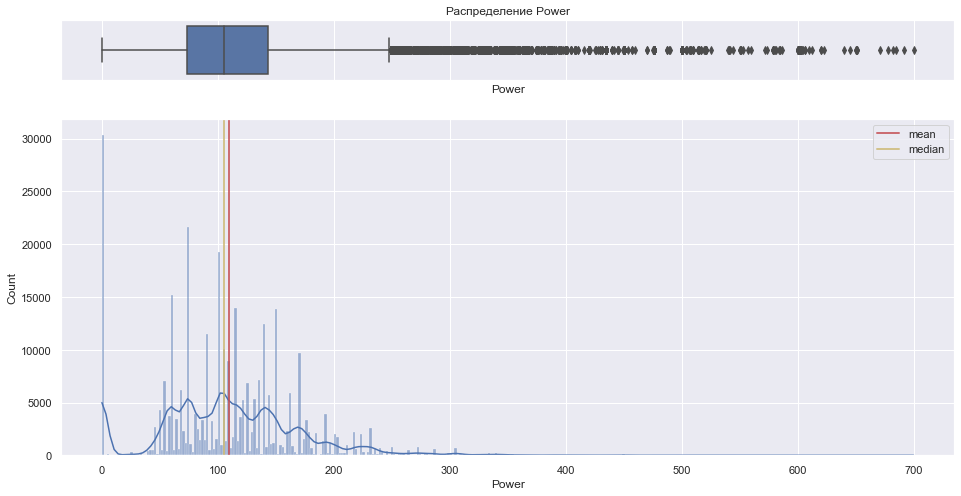

In [48]:
info_column(df['Power'], df, True)

Справа немного причесали. Не идеально конечно, но все же. Теперь околонулевые значения. У нас довольно большой датасет в котором я думаю можно найти информацию по большинству машин. Сделаем еще одну колонку в которую запишем пару производитель-марка.

In [49]:
df['BrandModel'] = df['Brand'] +" "+ df['Model']

In [50]:
df['BrandModel']

0                volkswagen golf
1                   audi unknown
2                     jeep grand
3                volkswagen golf
4                    skoda fabia
                   ...          
354363               opel zafira
354365    sonstige_autos unknown
354366              smart fortwo
354367    volkswagen transporter
354368           volkswagen golf
Name: BrandModel, Length: 320793, dtype: object

Теперь создадим сводную таблицу с мединаными значениями мощности для каждого авто.

In [51]:
df_brand_model_power = df.pivot_table(index=('BrandModel') , values='Power', aggfunc='median')

In [52]:
df_brand_model_power

,Power
BrandModel,
alfa_romeo 145,103.0
alfa_romeo 147,120.0
alfa_romeo 156,150.0
alfa_romeo 159,170.0
alfa_romeo other,150.0
...,...
volvo v40,116.0
volvo v50,136.0
volvo v60,163.0


Объеденим две таблицы.

In [53]:
df = df.join(df_brand_model_power, on='BrandModel', rsuffix='Median')
del (df_brand_model_power)

Теперь у нас есть столбец с медианным значением мощности двигателя от марки автомобиля. Мы можем использовать его для заполнения нулевых и нереально маленьких (<20) значений в изначальном столбце `Power`.

In [54]:
def filling_zeros_power(row):
    if row['Power'] < 20:
        return row['PowerMedian']
    return row['Power']

In [55]:
df['Power'] = df.apply(filling_zeros_power, axis=1)

Power
count    320793.000000
mean        119.546266
std          53.284195
min           0.000000
25%          75.000000
50%         110.000000
75%         147.000000
max         700.000000
Name: Power, dtype: float64


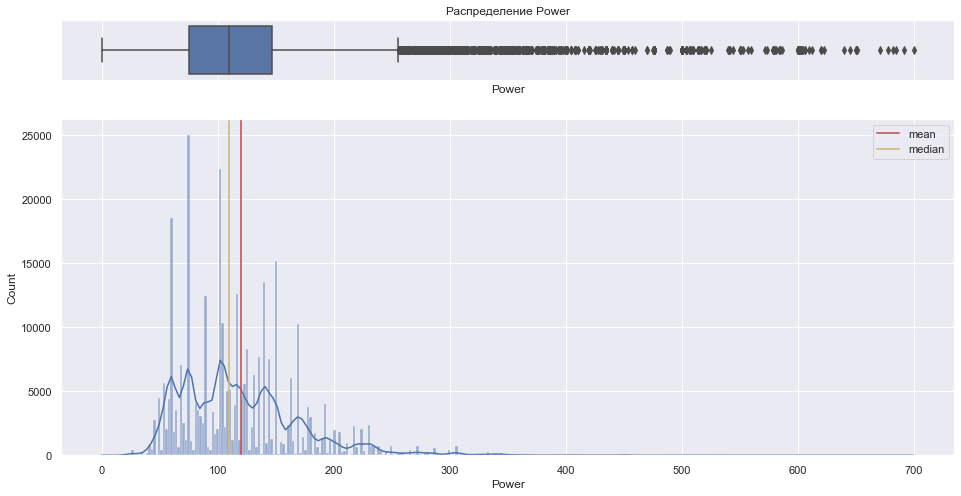

In [56]:
info_column(df['Power'], df)

Даже после этого заполнения у нас осталось некоторое количество нулевых значений в колонке мощности авто. Посмотрим на них глазами.

In [57]:
display(df[df['Power']<20].head())
df[df['Power']<20].shape

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,year_with_month,Age,BrandModel,PowerMedian
552,50,unknown,1985,unknown,0.0,unknown,150000,11,unknown,trabant,no,1985.833333,31.166667,trabant unknown,0.0
4361,800,unknown,1970,manual,0.0,unknown,20000,5,unknown,trabant,no,1970.333333,46.666667,trabant unknown,0.0
5625,2000,wagon,1987,manual,0.0,unknown,70000,5,petrol,trabant,no,1987.333333,29.666667,trabant unknown,0.0
10816,8,unknown,2015,unknown,0.0,unknown,125000,1,unknown,porsche,no,2015.000000,2.000000,porsche unknown,0.0
17255,500,unknown,1985,unknown,0.0,unknown,5000,1,unknown,trabant,no,1985.000000,32.000000,trabant unknown,0.0


(57, 15)

57 строк. Так как большинство параметров авто в этих строках нам не известны, врядли они могут нам пригодиться для обучения модели. Избавимся от них.

In [58]:
df = df.query('Power > 20')

In [59]:
size_change(df.shape[0], INITIAL_DF_LENGTH)

Размер изначального датасета: 354369 строк
Размер датасета сейчас: 320684 строк
Датасет сократился на 9.506 %


**Вывод:**

Данные оказались довольно "Грязными". Многие столбцы, которые содержат важную для построения модели информацию имели пропуски и аномалии. В результате предобработки мы потеряли 9.5% от нашего датасета. Предотвратить появление таких аномалий в будущем мы сможем, если дадим инструкции разработчикам сайта, как проверять данные на стадии внесения их в базу и какие из колонок нам обязательны для максимально точного прогноза.

## Обучение моделей

Приступим к обучению моделей. Для начала избавимся от ненужных колонок и разобьем выборку на тестовую и тренировочную.

In [60]:
def split_df(df, target_column_name:str, valid_test_flag:bool):
    
    '''
    This function takes dataframe, target column name and a flag, which means should it return train-valid-test df's 
    (features_train, features_valid, features_test and target_train, target_valid, target_test) or only train-test.
    In case if flag = False, than the function will split the df in proportion 75/25, if True - 60/20/20.
    '''
    
    if valid_test_flag:
        df_train, df_valid = train_test_split(df, test_size=0.2, 
                                              random_state=12345)
        df_train, df_test = train_test_split(df_train, test_size=0.25, 
                                             random_state=12345)
        
        features_train = df_train.drop([target_column_name], axis=1)
        target_train = df_train[target_column_name]
        
        features_valid = df_valid.drop([target_column_name], axis=1)
        target_valid = df_valid[target_column_name]
        
        features_test = df_test.drop([target_column_name], axis=1)
        target_test = df_test[target_column_name]
        
        return features_train, features_valid, features_test, target_train, target_valid, target_test
    
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=12345)
    
    features_train = df_train.drop([target_column_name], axis=1)
    target_train = df_train[target_column_name]
    
    features_test = df_test.drop([target_column_name], axis=1)
    target_test = df_test[target_column_name]
    
    return features_train, features_test, target_train, target_test

In [61]:
df.drop(
    columns=[
    'RegistrationYear', 
    'Model', 
    'Brand', 
    'RegistrationMonth', 
    'year_with_month',
    'PowerMedian'
            ], 
    inplace = True)

In [62]:
X_train, X_test, y_train, y_test = split_df(df, 'Price', False)

Подготовим список ктегориальных признаков.

In [63]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

In [64]:
del(df)

### Baseline

Для начала подготовим скоррер. Мы будем ориентироваться на метрику `RMSE`.

In [65]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

Как опорную точку будем использовать заполнение предсказаний медианной.

In [66]:
dummy_pred = pd.Series([y_test.median()] * len(y_test), index=y_test.index)

In [67]:
rmse(y_test, dummy_pred)

4870.254222356422

Предсказания мединым значением дают нам `rmse = 4870.25`

### LinearRegression

Для удобства оценивания моделей напишем функцию:
- На вход она получает получает модель, признаки для обучения и выборку для тестирования
- Внутри функции будет происходить обучение модели, и предсказания для теста
- Возвращает функция время обучения модели, время потраченное на предсказания, и `RMSE`, для сравнения моделей

Каждый раз мы будем сначала производить подбор гиперпараметров модели, а позже лучшую модель оценивать с помощью нашей функции.

In [68]:
def model_evaluation(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    training_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start

    return training_time, predict_time, rmse(y_test, y_pred)

In [69]:
result = []

Теперь обучим линейную регрессию. Но перед этим подготовим `pipeline`:
- Закодируем категориальные признаки методом `OneHotEncoder`
- Дискретные значения масштабируем при помощи `StandartScaller`
- В качестве модели будем использовать `Ridge`
- Параметр, который будем подбирать `model__alpha`

In [70]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', Ridge(random_state=SEED))
])

params = [
    {
        'model__alpha': np.logspace(-2, 2, 20)
    } 
]

Обучим нашу модель и подберем `alpha` с помощью `GridSearchCV`.

In [71]:
cv = KFold(n_splits=3, shuffle=True, random_state=SEED)

grid = GridSearchCV(pipe,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [72]:
%%time
grid.fit(X_train, y_train)

Wall time: 19.1 s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('ohe',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Ridge(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])}],
             scoring='neg_mean_squared_error', verbose=False)

In [73]:
grid.best_params_

{'model__alpha': 100.0}

Сохраним результаты лучшей модели.

In [74]:
result.append(model_evaluation(grid.best_estimator_, X_train, y_train, X_test, y_test))

In [75]:
del(grid)

### LGBMRegressor

Для этой модели немного изменим подход:
- Подготовим категориальные признаки через `LabelEncoder`
- Подберем лучшие параметры по сетке
- Обучим модель на `train` выборке и замеряем время и `RMSE`

In [76]:
encoder = LabelEncoder()

lgb_train = X_train.copy()
lgb_test = X_test.copy()

cat_col_num = []

for col in categorical:
    lgb_train[col] = encoder.fit_transform(lgb_train[col])
    lgb_test[col] = encoder.transform(lgb_test[col])
    cat_col_num.append(X_train.columns.to_list().index(col))

gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=SEED)


params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}

grid_gbm = GridSearchCV(gbm,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=0)

In [77]:
%%time
grid_gbm.fit(lgb_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(seed=12345, verbose=0),
             param_grid={'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                         'n_estimators': [40, 60], 'num_leaves': [21, 31, 41]},
             scoring='neg_mean_squared_error')

In [78]:
grid_gbm.best_params_

{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 41}

In [79]:
result.append(model_evaluation(grid_gbm.best_estimator_, lgb_train, y_train, lgb_test, y_test))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [80]:
del(grid_gbm, lgb_train, lgb_test)

###  CatBoostRegressor

Из официальной документации:
"CatBoost supports numerical, categorical and text features.
Categorical features are used to build new numeric features based on categorical features and their combinations."

То есть для этой библиотеки обработка категориальных признаков встроена в модель. Надо только указать какие признаки содержат категории.

В остальном действовать будем по той же схеме, что и для других моделей.

In [81]:
cbr = CatBoostRegressor(random_seed=SEED,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=categorical)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [8, 10],
}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [82]:
%%time
grid_cbr.fit(X_train, y_train)

Wall time: 4min 17s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001D0197342E0>,
             param_grid={'depth': [8, 10], 'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             scoring='neg_mean_squared_error', verbose=False)

In [83]:
grid_cbr.best_params_

{'depth': 10, 'iterations': 60, 'learning_rate': 0.1778279410038923}

In [84]:
result.append(model_evaluation(grid_cbr.best_estimator_, X_train, y_train, X_test, y_test))

### Вывод

Как мы видим само время гиперпараметров сильно зависит от типа выбранной модели и количества подбираемых гипперпараметров. Сам подбор занимает:
- Линейная регрессия Ridge - ~3.5min
- LGBMRegressor - ~7min
- CatBoostRegressor - ~24.5min

## Анализ моделей

Посмотрим на финальную таблицу сравнения моделей.

In [85]:
pd.DataFrame(data=result,
             index=['Ridge', 'LightGBM', 'CatBoost'],
             columns=['TrainingTime', 'PredictionTime', 'RMSE'])

,TrainingTime,PredictionTime,RMSE
Ridge,0.681737,0.132645,2023.259711
LightGBM,0.550805,0.090876,1694.863088
CatBoost,6.194975,0.130809,1752.448914


## Вывод

Все три модели смогли превзойти предсказания по медиане более чем в два раза.

Лучший показатель `RMSE` получен на модели `LightGBM`. При этом и скорость обучения у нее самая лучшая. Так же стоит отметить, что она выйграла по скорости и в подборе параметров в сравнении с `CatBoost` почти в 3 раза.

Для данной задачи эта модель подойдет лучше всего.

**Рекомендации по сбору данных**

Для более точных предсказаний следует улучшить качество данных на момент введения их пользователем. Для этого стоит сделать обязательными для заполнения поля, несущие наибольшую ценность для предсказания ключевого параметра. Также стоит ограничить степени свободы для данных, например ограничить возможность ввода даты выпуска авто из будущего. 

Возможно стоит воспользоваться какой-либо онлайн энциклопедией автомобилей, чтобы пользователь мог не вспоминать сколько у него лошадиных сил под капотом, а выбрать подходящее значение основываясь на годе выпуска и модификации авто.